In [201]:
import astropy.constants as const
import astropy.units as u
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from plotting import label_axes

# Threshold energy calculation for generic process

$$
a + b \to c + d + ...
$$

Given the mass of the projectile (a), the mass and energy of the target (b), the scattering angle and the "added mass" after the process ($\Delta m = \sum_{c,d,...} m - m_a - m_b$), calculate the threshold energy for the projectile.

From invariance of $s$ we write

$$
E_a E_b - \sqrt{E_a^2 - m_a^2} \sqrt{E_b^2 - m_b^2} \cos \theta = m_a m_b + \Delta m \left( m_a + m_b + \frac{\Delta m} {2} \right)
$$

Writing in terms of $x \equiv T_a = E_a - m_a$, we get

$$
x + m_a - \alpha \sqrt{x^2 + 2 x m_a} = \beta \\
\alpha \equiv \frac{ \sqrt{E_b^2 - m_b^2} \cos \theta }{E_b} \\
\beta \equiv \frac{ m_a m_b + \Delta m \left( m_a + m_b + \frac{\Delta m} {2} \right) } {E_b} \\
\to \alpha \sqrt{x^2 + 2 x m_a} = x + m_a - \beta
$$

This leads to a quadratic equation

$$
p_2 x^2 + p_1 x + p_0 = 0
$$

...with coefficients

$$
\begin{align}
p_2 &= \alpha^2 - 1 \; \\
p_1 &= 2 (m_a (\alpha^2 - 1) + \beta) \; \\
p_0 &= (m_a - \beta)^2 \;
\end{align}
$$

The quadratic equation might have two roots with only one being valid. The solution is made based on the sign of $\alpha$.

## Relativistic limit

The case of $m_a \ll E_a$. This leads to

$$
T_a = \frac{ m_a m_b + \Delta m \left( m_a + m_b + \frac{\Delta m} {2} \right) } {E_b - \sqrt{E_b^2 - m_b^2} \cos \theta} - m_a
$$


In [202]:
import math


def threshold_energy(
    proj_mass: u.Quantity[u.eV],
    target_mass: u.Quantity[u.eV],
    target_energy: u.Quantity[u.eV],
    scattering_angle: u.Quantity[u.dimensionless_unscaled],
    added_mass: u.Quantity[u.eV],
) -> u.Quantity[u.eV]:
    INF_THRESHOLD = np.inf * u.eV
    alpha = (
        np.sqrt(target_energy**2 - target_mass**2)
        * np.cos(scattering_angle)
        / target_energy
    ).decompose()
    beta = (
        (
            target_mass * proj_mass
            + added_mass * (target_mass + proj_mass + added_mass / 2)
        )
        / target_energy
    ).to(u.eV)
    m_a = proj_mass.to(u.eV)

    a = alpha**2 - 1
    b = 2 * (m_a * (alpha**2 - 1) + beta)
    c = -((m_a - beta) ** 2)
    if math.isclose(a, 0.0):
        return max(-c / b, 0.0 * u.eV)
    D = b**2 - 4 * a * c
    if D < 0:
        return INF_THRESHOLD

    x1, x2 = [(-b + sign * np.sqrt(D)) / (2 * a) for sign in (-1, 1)]
    lhs_sign = alpha > 0
    rhs = lambda x: x + m_a - beta
    rhs_sign = lambda x: rhs(x) > 0
    if rhs_sign(x1) == lhs_sign:
        return max(x1, 0.0 * u.eV)
    elif rhs_sign(x2) == lhs_sign:
        return max(x2, 0.0 * u.eV)
    elif np.abs(alpha) < 1e-10:
        if np.abs(rhs(x1)) < np.abs(rhs(x2)):
            return max(x1, 0.0 * u.eV)
        else:
            return max(x2, 0.0 * u.eV)
    else:
        return INF_THRESHOLD


def threshold_energy_relativistic_limit(
    proj_mass: u.Quantity[u.eV],
    target_mass: u.Quantity[u.eV],
    target_energy: u.Quantity[u.eV],
    scattering_angle: u.Quantity[u.dimensionless_unscaled],
    added_mass: u.Quantity[u.eV],
) -> u.Quantity[u.eV]:
    return max(
        (
            (
                target_mass * proj_mass
                + added_mass * (target_mass + proj_mass + added_mass / 2)
            )
            / (
                (
                    target_energy
                    - np.sqrt(target_energy**2 - target_mass**2)
                    * np.cos(scattering_angle)
                )
            )
        )
        - proj_mass,
        0.0 * u.eV,
    )

In [204]:
def plot_threshold_energy(
    proj_mass: u.Quantity[u.eV],
    target_mass: u.Quantity[u.eV],
    added_mass: u.Quantity[u.eV],
    target_kinenergy_limits_lgeV: tuple[float, float],
    label: str,
):
    theta_grid = np.linspace(0, np.pi, 9)
    # theta_grid = np.array([np.pi / 2])
    target_kinenergy_grid = np.logspace(*target_kinenergy_limits_lgeV, num=300) * u.eV

    _, ax = plt.subplots()
    cmap = matplotlib.colormaps["turbo"]
    for idx, theta in enumerate(theta_grid):
        color = cmap(idx / (theta_grid.size))
        for idx, (func, linestyle) in enumerate(
            ((threshold_energy, None), (threshold_energy_relativistic_limit, ":"))
        ):
            values = u.Quantity(
                [
                    func(
                        proj_mass=proj_mass,
                        target_mass=target_mass,
                        target_energy=T + target_mass,
                        added_mass=added_mass,
                        scattering_angle=theta,
                    ).to(u.GeV)
                    for T in target_kinenergy_grid
                ]
            )
            # print(values)

            ax.loglog(
                target_kinenergy_grid.to(u.GeV),
                values,
                color=color,
                linestyle=linestyle,
                label=(
                    f"$ \\theta = {theta * 180 / np.pi :.1f}^\\circ $"
                    if idx == 0
                    else None
                ),
            )
    label_axes(ax, "T_{\\mathrm{target}}", "T_{\\mathrm{thr}}")
    ax.legend()
    if proj_mass > 0:
        ax.axhline(proj_mass, color="k", linestyle="--", linewidth=0.3)
    if target_mass > 0:
        ax.axvline(target_mass, color="k", linestyle="--", linewidth=0.3)
    fmt = lambda E: E.to(u.GeV).to_string(format="latex", precision=2).strip("$")
    label = f"{label}\n$m_a = {fmt(proj_mass)}, m_b = {fmt(target_mass)}, \\Delta m = {fmt(added_mass)} $"
    if label is not None:
        ax.set_title(label)
    return ax

In [205]:
m_p = const.m_p * const.c**2
m_e = const.m_e * const.c**2

<Axes: title={'center': '$ \\gamma \\gamma \\to 2e^{\\pm} $\n$m_a = 0 \\; \\mathrm{GeV}, m_b = 0 \\; \\mathrm{GeV}, \\Delta m = 0.001 \\; \\mathrm{GeV} $'}, xlabel='$ T_{\\mathrm{target}} $ [$\\mathrm{GeV}$]', ylabel='$ T_{\\mathrm{thr}} $ [$\\mathrm{GeV}$]'>

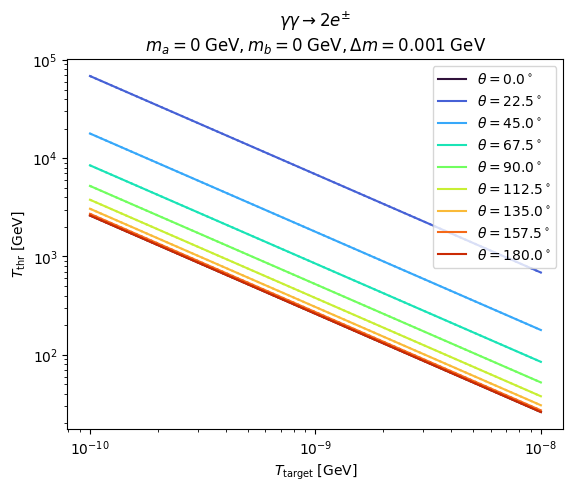

In [206]:
plot_threshold_energy(
    proj_mass=0 * u.eV,
    target_mass=0 * u.eV,
    added_mass=2 * m_e,
    target_kinenergy_limits_lgeV=(-1, 1),
    label="$ \\gamma \\gamma \\to 2e^{\\pm} $",
)

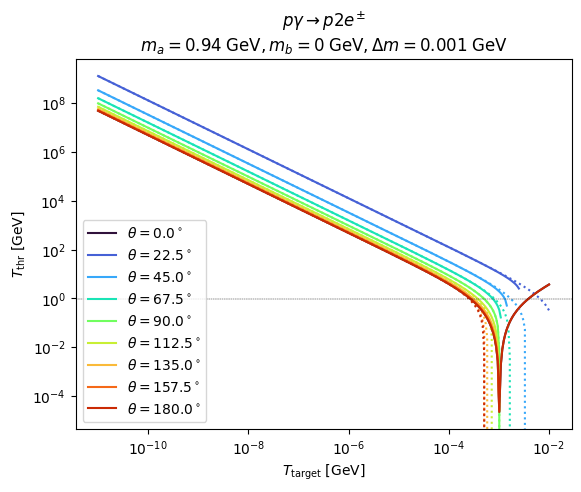

In [207]:
ax = plot_threshold_energy(
    proj_mass=m_p,
    target_mass=0.0 * u.eV,
    added_mass=2 * m_e,
    target_kinenergy_limits_lgeV=(-2, 7),
    label="$p \\gamma \\to p 2 e^{\\pm}$",
)

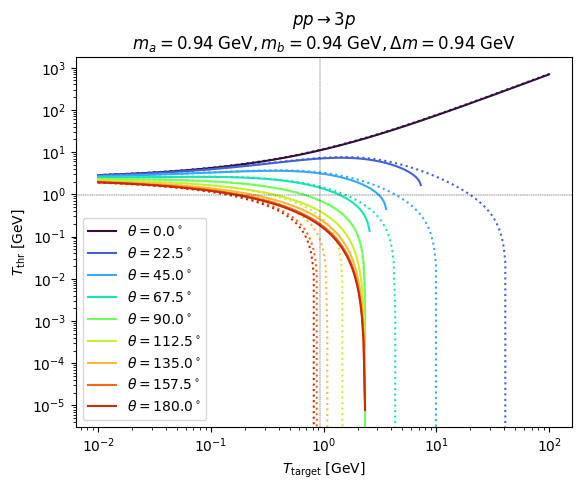

In [208]:
ax = plot_threshold_energy(
    proj_mass=m_p,
    target_mass=m_p,
    added_mass=m_p,
    target_kinenergy_limits_lgeV=(7, 11),
    label="$pp \\to 3p$",
);